# Создание аннотации для сайтов редактирования по семействам повторов

In [2]:
import pybedtools
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict
from pathlib import Path
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [9]:
path = '/home/mragletdinov/new_science/data'
path2 = '/home/mragletdinov/new_science/Intersection_by_repFamily/data'

## def

In [10]:
def chroms_list() -> list:
    """Функция создает список реальных хромосом."""
    chroms = ['chr'+ str(i) for i in range(1,23)]
    chroms.append('chrX')
    chroms.append('chrY')
    return chroms

In [11]:
def count_esites_in_repeats(esites: Path, repeats: Path) -> pd.DataFrame:
    """
    Функция принимает на вход два пути, по которым можно найти bed файлы сайтов 
    редактирования и повторов (семейства). Проводит их пересечение, тем самым создавая аннотацию последними.
    Затем происходит подсчет сайтов редактирования на каждый повтор, включая область, свободную
    от повторов. Аутпутом является датафрейм.
    """
    esites = pybedtools.BedTool(esites)
    repeats = pybedtools.BedTool(repeats)
    intersection = repeats.intersect(esites)

    counts = defaultdict(int)
    for inter in intersection:
        counts[inter.name] += inter.length

    counts['Repeat-free'] = len(esites.subtract(intersection))
    df = pd.DataFrame({"RepFamily": counts.keys(), "EditingSites": counts.values()})
    df.sort_values(by='EditingSites', ignore_index=True, inplace=True, ascending=False)
    return df

In [12]:
def group_rarely_edited_repeats(df, cutoff=21056):
    sub_df = df.copy()
    sub_df['RepFamily'] = sub_df['RepFamily'].where(sub_df['EditingSites'] > cutoff, "Other repeats")    
    sub_df = sub_df.groupby(sub_df.RepFamily, as_index=False).agg({'EditingSites':'sum'})
    sub_df.sort_values('EditingSites', ascending=False, inplace=True)
    sub_df = sub_df.reset_index(drop=True)
    #Перемещение строки с Other_repeats в конец таблицы
    tobottom = sub_df.index[sub_df['RepFamily'] == 'Other repeats'][0]
    index = sub_df.index.tolist()
    index.pop(tobottom)
    sub_df = sub_df.reindex(index+[tobottom])
    sub_df = sub_df.reset_index(drop=True)
    return (sub_df, tobottom)

## Сайты редактирования редипортал

In [13]:
esites = pybedtools.BedTool(f"{path}/esites_filt.bed.gz")

In [14]:
esites.head(5)

chr1	87158	87159
 chr1	87168	87169
 chr1	87171	87172
 chr1	87189	87190
 chr1	87218	87219
 

In [15]:
len(esites)

15679823

## Повторы с репит маскера

In [16]:
df_repeat = df_repeats = pd.read_csv(f'{path2}/new_hg-repeat-masker_repFamily.bed.gz', 
                        on_bad_lines='skip',
                        sep='\t',
                        )

In [17]:
df_repeat.head()

,chrom,chromStart,chromEnd,repFamily
0,chr1,10000,10468,Simple_repeat
1,chr1,10468,11447,Satellite
2,chr1,11504,11675,L1
3,chr1,11677,11780,hAT-Charlie
4,chr1,15264,15355,MIR


In [18]:
df_repeat.shape

(5456300, 4)

In [19]:
df_repeat.chrom.unique()

array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr1_GL383518v1_alt',
       'chr1_GL383519v1_alt', 'chr1_GL383520v2_alt',
       'chr1_KI270759v1_alt', 'chr1_KI270760v1_alt',
       'chr1_KI270761v1_alt', 'chr1_KI270762v1_alt',
       'chr1_KI270763v1_alt', 'chr1_KI270764v1_alt',
       'chr1_KI270765v1_alt', 'chr1_KI270766v1_alt',
       'chr1_KI270892v1_alt', 'chr1_KN196472v1_fix',
       'chr1_KN196473v1_fix', 'chr1_KN196474v1_fix',
       'chr1_KN538360v1_fix', 'chr1_KN538361v1_fix',
       'chr1_KQ031383v1_fix', 'chr1_KQ458382v1_alt',
       'chr1_KQ458383v1_alt', 'chr1_KQ458384v1_alt',
       'chr1_KQ983255v1_alt', 'chr1_KV880763v1_alt',
       'chr1_KZ208904v1_alt', 'chr1_KZ208905v1_alt',
       'chr1_KZ208906v1_fix', 'chr1_KZ559100v1_fix', 'chr2', 'chr20',
       'chr21', 'chr22', 'chr2_GL383521v1_alt', 'chr2_GL383522v1_alt',
       'chr2_GL582966v2_alt', 'chr2_KI270767v1_alt',
       'chr2_KI270768v1_alt', 'chr2

In [20]:
repeats = pybedtools.BedTool(f'{path2}/new_hg-repeat-masker_repFamily.bed.gz')

In [21]:
repeats.head(10)

chrom	chromStart	chromEnd	repFamily
 chr1	10000	10468	Simple_repeat
 chr1	10468	11447	Satellite
 chr1	11504	11675	L1
 chr1	11677	11780	hAT-Charlie
 chr1	15264	15355	MIR
 chr1	15797	15849	Simple_repeat
 chr1	16712	16744	Simple_repeat
 chr1	18906	19048	L2
 chr1	19971	20405	CR1
 

Выберем только 24 хромосомы

In [22]:
mask = df_repeats.chrom.isin(chroms_list())

In [23]:
df_repeats = df_repeats[mask]

In [24]:
df_repeats

,chrom,chromStart,chromEnd,repFamily
0,chr1,10000,10468,Simple_repeat
1,chr1,10468,11447,Satellite
2,chr1,11504,11675,L1
3,chr1,11677,11780,hAT-Charlie
4,chr1,15264,15355,MIR
...,...,...,...,...
5456295,chrY,57214796,57214899,hAT-Charlie
5456296,chrY,57214901,57215093,L1
5456297,chrY,57215116,57216403,Satellite
5456298,chrY,57216406,57217320,Simple_repeat


In [25]:
df_repeats.reset_index(drop=True, inplace=True)
df_repeats

,chrom,chromStart,chromEnd,repFamily
0,chr1,10000,10468,Simple_repeat
1,chr1,10468,11447,Satellite
2,chr1,11504,11675,L1
3,chr1,11677,11780,hAT-Charlie
4,chr1,15264,15355,MIR
...,...,...,...,...
5317281,chrY,57214796,57214899,hAT-Charlie
5317282,chrY,57214901,57215093,L1
5317283,chrY,57215116,57216403,Satellite
5317284,chrY,57216406,57217320,Simple_repeat


Проверим на дубликаты.

In [26]:
len(df_repeats)

5317286

In [27]:
df_repeats = df_repeats.drop_duplicates()

In [28]:
df_repeats = df_repeats.dropna()

In [29]:
df_repeats = df_repeats.astype({'chromStart':'int32', 'chromEnd':'int32'})

In [30]:
df_repeats

,chrom,chromStart,chromEnd,repFamily
0,chr1,10000,10468,Simple_repeat
1,chr1,10468,11447,Satellite
2,chr1,11504,11675,L1
3,chr1,11677,11780,hAT-Charlie
4,chr1,15264,15355,MIR
...,...,...,...,...
5317281,chrY,57214796,57214899,hAT-Charlie
5317282,chrY,57214901,57215093,L1
5317283,chrY,57215116,57216403,Satellite
5317284,chrY,57216406,57217320,Simple_repeat


In [31]:
len(df_repeats)#Размер тот же. Значит файл был уже почищен

5317286

In [32]:
df_repeats_group = df_repeats.groupby(by=['chrom','chromStart','chromEnd']) \
                    .aggregate({'repFamily':'count'}) \
                    .rename(columns={'repFamily':'count'})

In [33]:
df_repeats_group.head(5)

count
chrom chromStart chromEnd       
chr1  10000      10468         1
      10468      11447         1
      11504      11675         1
      11677      11780         1
      15264      15355         1

In [34]:
df_repeats_group.query('count == 2')
#строк,которые имеют одинаковые координаты, но РАЗНЫЕ имена НЕТ. И это хорошо.

,,,count
chrom,chromStart,chromEnd,


In [35]:
#Если бы были дубли по названиям семейств - так можно проверять
#df_repeats.query('chromStart == 10000' and 'chromEnd == 10038')

In [36]:
df_repeats.query('chromStart == 46809360' and 'chromEnd == 46809361')

,chrom,chromStart,chromEnd,repFamily


In [37]:
df_repeats.sort_values(by=['chrom','chromStart','chromEnd'], ignore_index=True, inplace=True)

In [38]:
df_repeats

,chrom,chromStart,chromEnd,repFamily
0,chr1,10000,10468,Simple_repeat
1,chr1,10468,11447,Satellite
2,chr1,11504,11675,L1
3,chr1,11677,11780,hAT-Charlie
4,chr1,15264,15355,MIR
...,...,...,...,...
5317281,chrY,57214796,57214899,hAT-Charlie
5317282,chrY,57214901,57215093,L1
5317283,chrY,57215116,57216403,Satellite
5317284,chrY,57216406,57217320,Simple_repeat


In [39]:
df_repeats.to_csv(f'{path2}/repeats_by_family.bed.gz', sep='\t',
                 header=None,
                 index=False,
                 compression='gzip'
                 )

## Теперь все верно. Файл в правильном формате

In [40]:
repeats = pybedtools.BedTool(f"{path2}/repeats_by_family.bed.gz")

In [41]:
repeats.head()

chr1	10000	10468	Simple_repeat
 chr1	10468	11447	Satellite
 chr1	11504	11675	L1
 chr1	11677	11780	hAT-Charlie
 chr1	15264	15355	MIR
 chr1	15797	15849	Simple_repeat
 chr1	16712	16744	Simple_repeat
 chr1	18906	19048	L2
 chr1	19971	20405	CR1
 chr1	20530	20679	CR1
 

## Проведем пересечение esites и repeats

In [42]:
edits = count_esites_in_repeats(esites=f"{path}/esites_filt.bed.gz",
                       repeats=f"{path2}/repeats_by_family.bed.gz")

In [43]:
edits

,RepFamily,EditingSites
0,Alu,14346666
1,L1,481594
2,Repeat-free,463387
3,ERVL-MaLR,154362
4,ERV1,54129
5,TcMar-Tigger,32079
6,MIR,26293
7,Simple_repeat,23054
8,hAT-Charlie,22206
9,L2,21055


In [44]:
sub_edits = group_rarely_edited_repeats(edits)

In [45]:
sub_edits[0]

,RepFamily,EditingSites
0,Alu,14346666
1,L1,481594
2,Repeat-free,463387
3,ERVL-MaLR,154362
4,ERV1,54129
5,TcMar-Tigger,32079
6,MIR,26293
7,Simple_repeat,23054
8,hAT-Charlie,22206
9,Other repeats,80177


In [37]:
with open(f'{path2}/real_edits_by_Rep_Family.pickle', 'wb') as f:
    pickle.dump(sub_edits[0], f)

In [46]:
sub_edits[0].rename(columns={'RepFamily':'Repeat family', 'EditingSites':'Number of editing sites'}, inplace=True)

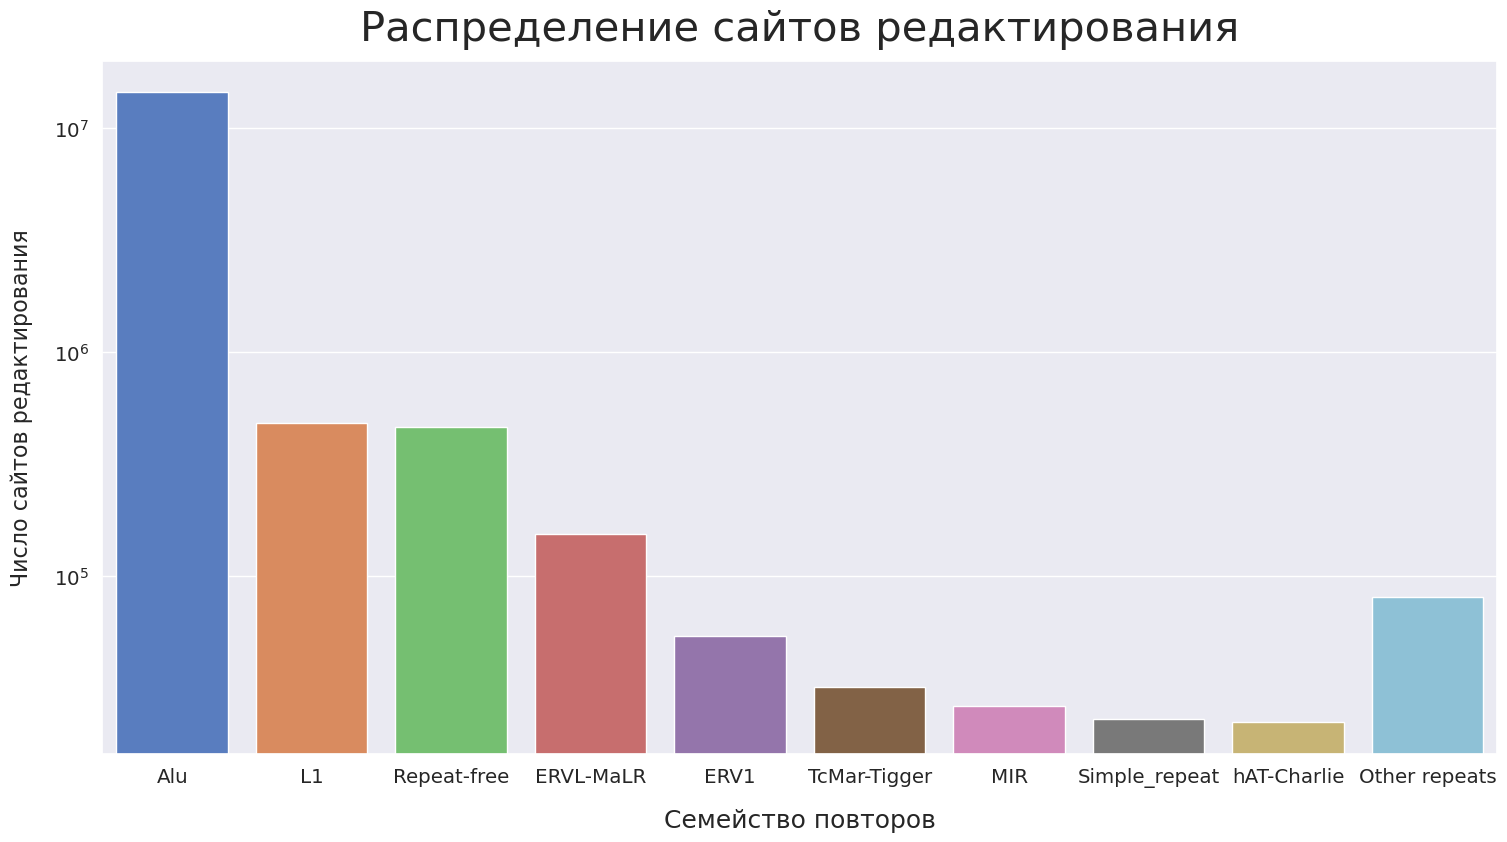

In [58]:
sns.set(rc={'figure.figsize':(16,8)}, font_scale = 1.3)
fig, ax = plt.subplots(figsize=(18, 9))
sns.barplot(x="Repeat family", y="Number of editing sites", data=sub_edits[0], palette='muted', order=sub_edits[0]['Repeat family'], ax=ax)
ax.set_yscale("log")
ax.set_title('Распределение сайтов редактирования',fontsize=30, pad=15)
ax.set_ylabel("Число сайтов редактирования",fontsize=16, labelpad=15)
ax.set_xlabel("Семейство повторов",fontsize=18, labelpad=15)
fig.savefig(f"{path}/images/Распределение сайтов редактирования по семействам повторов.jpg")

sns.set(rc={'figure.figsize':(20,12)}, font_scale = 1.3)
ax = sns.barplot(x="Repeat family", y="Number of editing sites", data=sub_edits[0], palette='muted', order=sub_edits[0]['Repeat family'])
ax.set_yscale("log")
ax.set_title('Distribution of editing sites by repeat family',fontsize=30)
ax.set_ylabel("Number of editing sites",fontsize=15)
ax.set_xlabel("Repeat family",fontsize=15)
fig = ax.get_figure()
fig.savefig(f"{path}/Distribution_of_esites_by_RepFamily.jpg")

# Теперь рассмотрим лишь сайты редактирования в генах

In [86]:
esites = pybedtools.BedTool(f"{path}/esites_filt.bed.gz")
esites.head(5)

chr1	87158	87159
 chr1	87168	87169
 chr1	87171	87172
 chr1	87189	87190
 chr1	87218	87219
 

In [87]:
genes = pybedtools.BedTool(f"{path}/genes_by_chrom.bed")
genes.head(5)

chr1	11868	14409	+
 chr1	14403	29570	-
 chr1	29553	31109	+
 chr1	34553	36081	-
 chr1	52472	53312	+
 

In [91]:
len(genes)

49752

In [88]:
esites_in_genes = genes.intersect(esites)

In [89]:
esites_in_genes.head(5)

chr1	90937	90938	-
 chr1	90946	90947	-
 chr1	90958	90959	-
 chr1	90959	90960	-
 chr1	91035	91036	-
 

In [62]:
len(esites_in_genes)

14462126

In [92]:
df_esites_in_genes = pd.read_table(esites_in_genes.fn, names=['chrom', 'start', 'stop'], index_col=False)
df_esites_in_genes

/tmp/ipykernel_6785/776909453.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_esites_in_genes = pd.read_table(esites_in_genes.fn, names=['chrom', 'start', 'stop'], index_col=False)


,chrom,start,stop
0,chr1,90937,90938
1,chr1,90946,90947
2,chr1,90958,90959
3,chr1,90959,90960
4,chr1,91035,91036
...,...,...,...
14462121,chr22,50781162,50781163
14462122,chr22,50781183,50781184
14462123,chr22,50781232,50781233
14462124,chr22,50781294,50781295


In [93]:
df_esites_in_genes.shape

(14462126, 3)

In [94]:
df_esites_in_genes.to_csv(f'{path}/esites_filt_in_genes.bed.gz', sep='\t',
                 header=None,
                 index=False,
                 compression='gzip'
                 )

In [95]:
esites_in_genes = pybedtools.BedTool(f"{path}/esites_filt_in_genes.bed.gz")

In [96]:
esites_in_genes.head(5)

chr1	90937	90938
 chr1	90946	90947
 chr1	90958	90959
 chr1	90959	90960
 chr1	91035	91036
 

In [97]:
len(esites_in_genes)

14462126

In [98]:
edits_in_genes = count_esites_in_repeats(esites=f"{path}/esites_filt_in_genes.bed.gz",
                       repeats=f"{path2}/repeats_by_family.bed.gz")

In [99]:
sub_edits_in_genes = group_rarely_edited_repeats(edits_in_genes)

In [100]:
sub_edits_in_genes[0]

,RepFamily,EditingSites
0,Alu,13256775
1,Repeat-free,485202
2,L1,395257
3,ERVL-MaLR,121261
4,ERV1,36858
5,TcMar-Tigger,30835
6,MIR,25562
7,hAT-Charlie,21921
8,Simple_repeat,21263
9,Other repeats,70887


In [105]:
sub_edits_in_genes[0].rename(columns={'RepFamily':'Repeat family', 'EditingSites':'Number of editing sites'}, inplace=True)

In [106]:
with open(f'{path2}/real_edits_by_Rep_Family_in_genes.pickle', 'wb') as f:
    pickle.dump(sub_edits_in_genes[0], f)

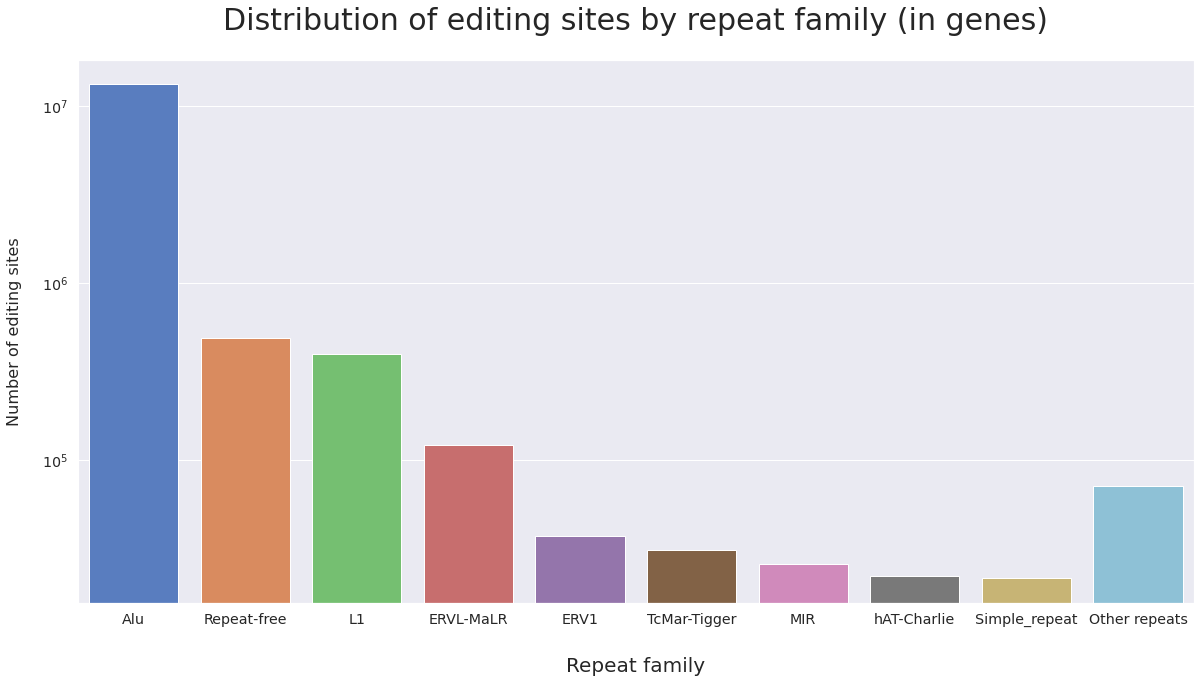

In [107]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="Repeat family", y="Number of editing sites", data=sub_edits_in_genes[0], palette='muted', order=sub_edits_in_genes[0]['Repeat family'], ax=ax)
ax.set_yscale("log")
ax.set_title('Distribution of editing sites by repeat family (in genes)',fontsize=30, pad=30)
ax.set_ylabel("Number of editing sites",fontsize=16, labelpad=20)
ax.set_xlabel("Repeat family",fontsize=20, labelpad=30)
fig.savefig(f"{path}/Distribution_of_esites_by_RepFamily_in_genes.jpg")